[[0.87076834 3.92400208 0.02584581]
 [0.72993393 3.78682126 0.02510029]
 [0.84122772 2.80005336 0.02791881]
 [1.57031183 3.76724648 0.02573689]]


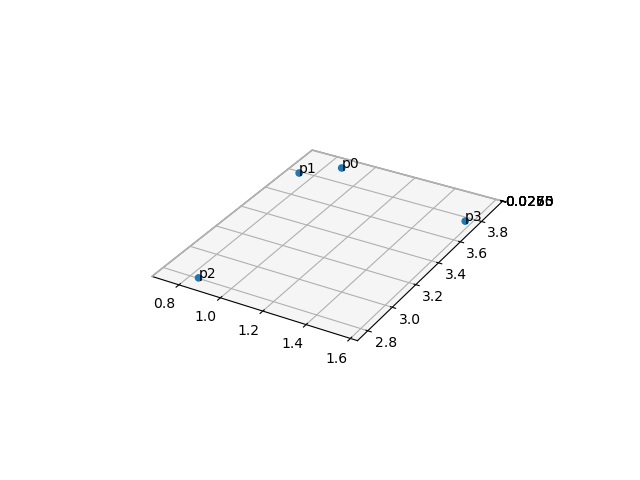

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from skspatial.objects import Plane, Points, LineSegment, Vector, Line
# from SE3 import se3, SE3
from lienp.SE3 import SE3
from lienp.SO3 import SO3

import pickle, json

cam_id = 3
with open(f"../scripts/calib_data{cam_id}.pkl", "rb") as fs:
    calib_data = pickle.load(fs)

markers_mean = Points(np.mean(calib_data['markers'], axis=0))
print(markers_mean)
plane = Plane.best_fit(markers_mean)
point = plane.project_point(markers_mean[0,:])
markers_p = Points([plane.project_point(marker) for marker in markers_mean])

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(markers_p[:,0], markers_p[:,1],markers_p[:,2], alpha=1)
for i, txt in enumerate(np.arange(markers_mean.shape[0])):
    ax.text(markers_p[i,0], markers_p[i,1], markers_p[i,2], f"p{i}", None)
ax.set_aspect('equal')

In [2]:
p0, p1, p2, p3 = markers_p


# vec1 = Vector(p0 - p1)
# seg1 = LineSegment(p0, p1)
# vec2 = Vector(p3 - p2)
# seg2 = LineSegment(p3, p2)

vec1 = Vector(p0 - p2)
seg1 = LineSegment(p0, p2)
vec2 = Vector(p1 - p3)
seg2 = LineSegment(p1, p3)


board_origin = seg1.intersect_line_segment(seg2)
print(f'board_origin: {board_origin}')
board_x = Vector(p2 - board_origin) # fix the board x to be the long side
board_x = board_x / board_x.norm()
board_z = plane.normal / plane.normal.norm()
board_y = board_z.cross(board_x)

R_board = np.array([board_x, board_y, board_z])
c_board = np.array(board_origin)
T_board = SE3(R=R_board, c=board_origin)

n_cols = 5
n_rows = 7
dim = 0.142
board_corners = []
for i in np.arange(n_rows):
    for j in np.arange(n_cols):
        corner = [j * dim, i * dim, -0.008]
        board_corners.append(corner)
board_corners = Points(board_corners)

T_board_offset = SE3(param=np.array([0, dim * 6, 0, 0, 0, np.pi/2]))

board_corners_corr = (T_board.inv @ T_board_offset.M @ np.vstack([board_corners.T, np.ones(35)]))[0:-1, :].T
print(board_corners_corr.shape)

board_origin: [0.86707903 3.78362774 0.02563817]
(35, 3)


In [3]:
def draw_ref_frame(ax, T: SE3, scale=1, alpha=.5):
    c = T.c
    R = T.R
    l1 = Line(c, R[0,:])
    l2 = Line(c, R[1,:])
    l3 = Line(c, R[2,:])
    ax1 = LineSegment(c, l1.to_point(scale))
    ax2 = LineSegment(c, l2.to_point(scale))
    ax3 = LineSegment(c, l3.to_point(scale))
    ax1.plot_3d(ax, color='r', alpha=alpha)
    ax2.plot_3d(ax, color='g', alpha=alpha)
    ax3.plot_3d(ax, color='b', alpha=alpha)
    ax.set_aspect("equal")

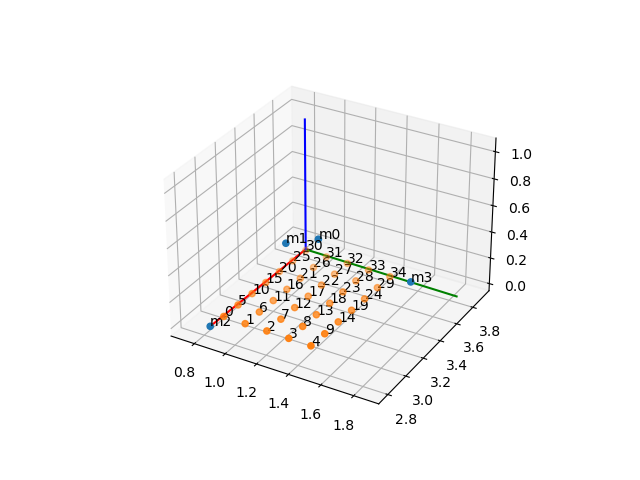

In [4]:
fig2 = plt.figure()
ax = fig2.add_subplot(111, projection='3d')

markers_p.plot_3d(ax, alpha=1)

# ax.set_aspect("equal")
for i, txt in enumerate(np.arange(markers_mean.shape[0])):
    ax.text(markers_p[i,0], markers_p[i,1], markers_p[i,2], f"m{i}", None)

Points(board_corners_corr).plot_3d(ax)
for i, txt in enumerate(np.arange(board_corners.shape[0])):
    ax.text(board_corners_corr[i,0], board_corners_corr[i,1], board_corners_corr[i,2], f"{i}", None)

Line(board_origin, board_x).plot_3d(ax, color='r')
Line(board_origin, board_y).plot_3d(ax, color='g')
Line(board_origin, board_z).plot_3d(ax, color='b')

In [5]:
import os, yaml, cv2
info_dir = os.path.abspath( os.path.join(os.path.dirname(''), os.pardir)) + "/camera_info/"
with open(f'{info_dir}/camera{cam_id}.yaml', 'r') as fs:
    cam_info = yaml.safe_load(fs)
K = np.array(cam_info["camera_matrix"]["data"])
cam_dist = np.array(cam_info["distortion_coefficients"]["data"])
K_opt, dist_valid_roi = cv2.getOptimalNewCameraMatrix(K.reshape(3,3), cam_dist, (1600,1200), 1, (1600, 1200))


(35, 2)


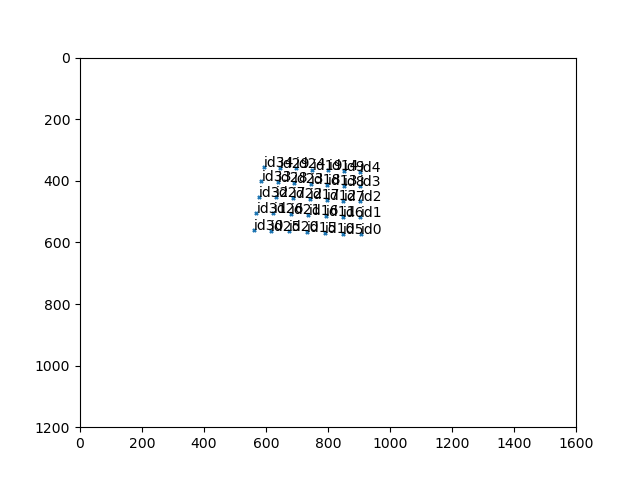

In [6]:
frame = 2
charuco_corners = np.array(calib_data['corners'][frame])
print(charuco_corners.shape)
charuco_corners_rect = cv2.undistortPoints(np.expand_dims(charuco_corners, axis=0), K.reshape(3,3), cam_dist, P=K_opt)
charuco_corners_rect = np.squeeze(charuco_corners_rect)

fig2 = plt.figure()
ax = fig2.add_subplot(111)
ax.set_xlim(0,1600)
ax.set_ylim(1200,0)
# ax.scatter(charuco_corners[:,0], charuco_corners[:,1], s=1)
ax.scatter(charuco_corners_rect[:,0], charuco_corners_rect[:,1], s=5, marker='x')
for i, txt in enumerate(calib_data['ids'][frame]):
    ax.text(charuco_corners_rect[i,0], charuco_corners_rect[i,1], f"id{txt}", None)

In [7]:
import sys
module_path = os.path.abspath(os.path.join('../scripts'))
if module_path not in sys.path:
    sys.path.append(module_path)
from lpnp import solve_lpnp
board_corners_corr.shape[0]
T_op, res = solve_lpnp(image_points=charuco_corners_rect, object_points=board_corners_corr, K_opt=K_opt)
T_op, res

(array([[ 2.26662316e-01,  5.42797759e-03, -9.73958280e-01,
          1.15576548e+00],
        [-2.94265689e-02,  9.99566128e-01, -1.27754108e-03,
         -3.22451844e+00],
        [ 9.73528773e-01,  2.89498208e-02,  2.26723701e-01,
         -8.04895784e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]]),
 array([[-4.92902777e-14],
        [-2.25540431e-14],
        [ 1.17113785e-13],
        [-1.75632589e-15],
        [ 8.48300674e-14],
        [ 1.43663082e-14]]))

In [8]:
cam_mocap_pose = calib_data['cam_mocap_pose'][99]
print(cam_mocap_pose)

[ 0.55803131  3.1999856   1.32160583  0.786251   -0.01881494  0.61740145
  0.01645614]


In [9]:
cam_mocap_pose = calib_data['cam_mocap_pose'][frame]
print(cam_mocap_pose)
q = cam_mocap_pose[3:7]
R_mocap = SO3.from_quat(q)
T_cam_mocap = SE3(R=SO3.from_quat(cam_mocap_pose[3:]).T, c=cam_mocap_pose[0:3])
T_calib = T_op @ T_cam_mocap.inv
print(T_calib)
with open(f'../camera_info/camera{cam_id}_mocap_calib.json', 'w') as fs:
    data = {"R": T_calib.R.tolist(), "c": T_calib.c.tolist()}
    json.dump(data, fs)

[ 0.55801917  3.20000854  1.32156628  0.78618185 -0.01882578  0.61748822
  0.01649191]
array([[ 0.99994117,  0.00326717, -0.01034293,  0.01246655],
       [-0.00304845,  0.9997729 ,  0.02109155, -0.04400726],
       [ 0.01040949, -0.02105878,  0.99972404,  0.13062199],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])


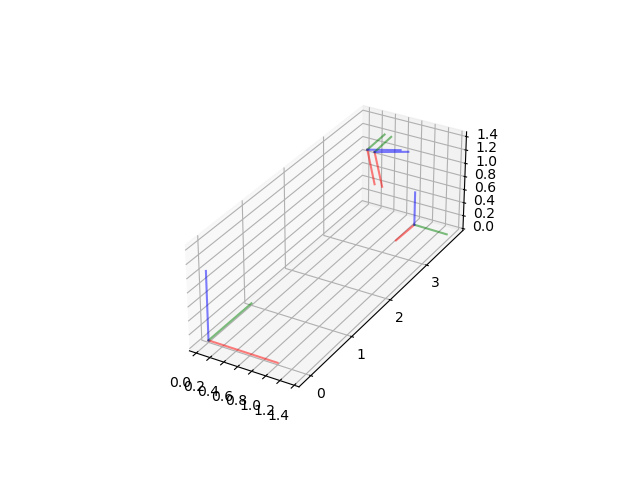

In [10]:

fig_ = plt.figure()
ax = fig_.add_subplot(111, projection='3d')
draw_ref_frame(ax, SE3(np.zeros(6)))
draw_ref_frame(ax, T_op, scale=0.5)
draw_ref_frame(ax, T_board, scale=0.5)
draw_ref_frame(ax, T_cam_mocap, scale=0.5)
